In [171]:
# Prepare a prediction model for profit of 50_startups data.
# Do transformations for getting better predictions of profit and
# make a table containing R^2 value for each prepared model.


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats

In [28]:
# Importing data
df = pd.read_csv(r"50_Startups.csv")

In [29]:
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [30]:
df.shape

(50, 5)

In [31]:
# Checking datatypes
df.dtypes

R&D Spend          float64
Administration     float64
Marketing Spend    float64
State               object
Profit             float64
dtype: object

In [32]:
# Checking dupliacte values
df[df.duplicated()]

,R&D Spend,Administration,Marketing Spend,State,Profit


In [33]:
# Finding Missing Values
df[df.isnull().any(axis=1)]

,R&D Spend,Administration,Marketing Spend,State,Profit


In [34]:
# Renaming column names

df.rename(columns = {'R&D Spend':'RDS'}, inplace = True)
df.rename(columns = {'Marketing Spend':'MS'}, inplace = True)
df.rename(columns = {'Profit':'P'}, inplace = True)
df.rename(columns = {'Administration':'A'}, inplace = True)

In [137]:
df.head(2)

,RDS,A,MS,State,P
0,165349.2,136897.80,471784.10,New York,192261.83
1,162597.7,151377.59,443898.53,California,191792.06


In [36]:
df["State"].unique()

array(['New York', 'California', 'Florida'], dtype=object)

In [37]:
# Perform one-hot encoding on state as it is a categorical variable
dfnew = pd.get_dummies(df, columns=['State'], prefix=['State'])

# Display the original and one-hot encoded DataFrames
print("Original DataFrame:")
print(df)
print("\nOne-Hot Encoded DataFrame:")
print(dfnew)

Original DataFrame:
          RDS          A         MS       State          P
0   165349.20  136897.80  471784.10    New York  192261.83
1   162597.70  151377.59  443898.53  California  191792.06
2   153441.51  101145.55  407934.54     Florida  191050.39
3   144372.41  118671.85  383199.62    New York  182901.99
4   142107.34   91391.77  366168.42     Florida  166187.94
5   131876.90   99814.71  362861.36    New York  156991.12
6   134615.46  147198.87  127716.82  California  156122.51
7   130298.13  145530.06  323876.68     Florida  155752.60
8   120542.52  148718.95  311613.29    New York  152211.77
9   123334.88  108679.17  304981.62  California  149759.96
10  101913.08  110594.11  229160.95     Florida  146121.95
11  100671.96   91790.61  249744.55  California  144259.40
12   93863.75  127320.38  249839.44     Florida  141585.52
13   91992.39  135495.07  252664.93  California  134307.35
14  119943.24  156547.42  256512.92     Florida  132602.65
15  114523.61  122616.84  261776.23 

In [38]:
dfnew.head(5)

,RDS,A,MS,P,State_California,State_Florida,State_New York
0,165349.20,136897.80,471784.10,192261.83,0,0,1
1,162597.70,151377.59,443898.53,191792.06,1,0,0
2,153441.51,101145.55,407934.54,191050.39,0,1,0
3,144372.41,118671.85,383199.62,182901.99,0,0,1
4,142107.34,91391.77,366168.42,166187.94,0,1,0


In [39]:
# dropping one extra variable to avoid multicollinearity

dfnew.drop('State_New York', axis=1, inplace = True)

In [40]:
dfnew.head(5)

,RDS,A,MS,P,State_California,State_Florida
0,165349.20,136897.80,471784.10,192261.83,0,0
1,162597.70,151377.59,443898.53,191792.06,1,0
2,153441.51,101145.55,407934.54,191050.39,0,1
3,144372.41,118671.85,383199.62,182901.99,0,0
4,142107.34,91391.77,366168.42,166187.94,0,1


In [41]:
dfnew.rename(columns = {'State_California':'SC'}, inplace = True)
dfnew.rename(columns = {'State_Florida':'SF'}, inplace = True)
dfnew = dfnew[['RDS', 'A', 'MS', 'SC', 'SF', 'P']]

In [42]:
dfnew.head(5)

,RDS,A,MS,SC,SF,P
0,165349.20,136897.80,471784.10,0,0,192261.83
1,162597.70,151377.59,443898.53,1,0,191792.06
2,153441.51,101145.55,407934.54,0,1,191050.39
3,144372.41,118671.85,383199.62,0,0,182901.99
4,142107.34,91391.77,366168.42,0,1,166187.94


## Using box plot to detect the outliers

Indices of outliers from the box plots:
[49]


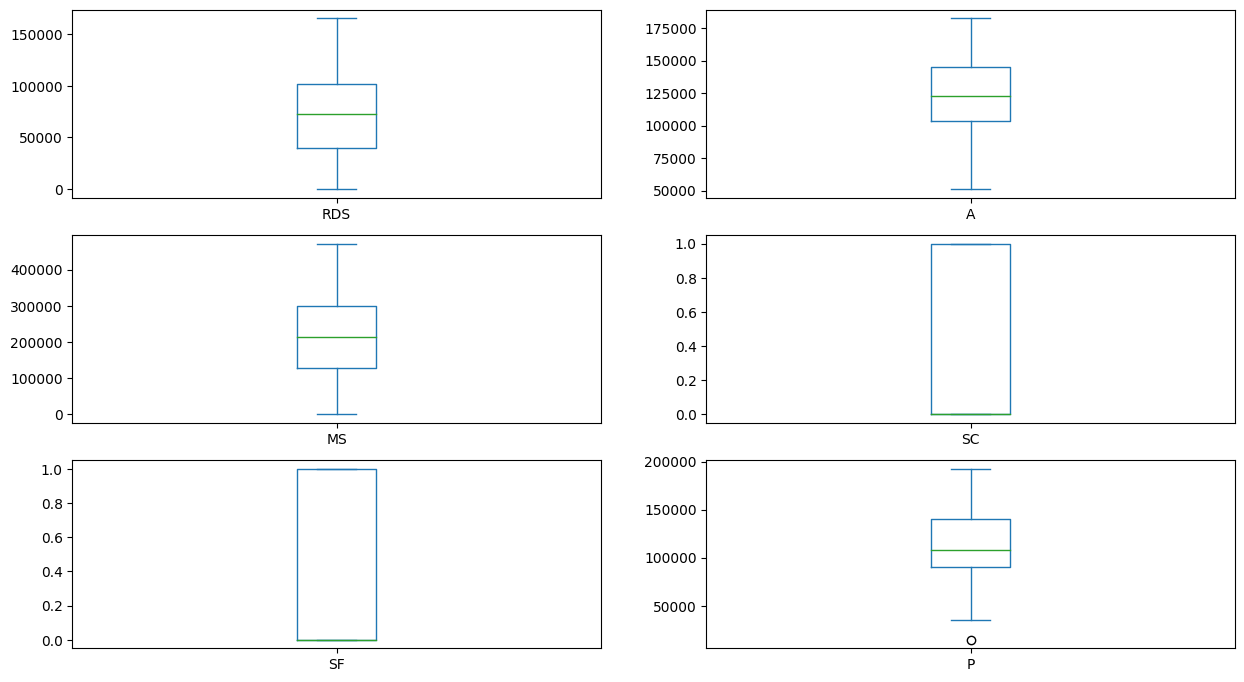

In [43]:
# Box plot find the outliers 

box_plot = dfnew.plot(kind="box",subplots=True,layout=(7,2),figsize=(15,20));

# Calculate the IQR for each variable
Q1 = dfnew.quantile(0.25)
Q3 = dfnew.quantile(0.75)
IQR = Q3 - Q1

# Set the IQR multiplier for identifying potential outliers
IQR_multiplier = 1.5  # Adjust as needed

# Get the indices of the outliers
outlier_indices = []

for col, ax in zip(dfnew.columns, box_plot):
    outliers = ((dfnew[col] < (Q1[col] - IQR_multiplier * IQR[col])) | (dfnew[col] > (Q3[col] + IQR_multiplier * IQR[col])))
    col_outlier_indices = dfnew.index[outliers]
    outlier_indices.extend(col_outlier_indices)

outlier_indices = list(set(outlier_indices))  # Remove duplicate indices

# Display the outlier indices
print("Indices of outliers from the box plots:")
print(outlier_indices)

## Using IQR to detect the outliers 

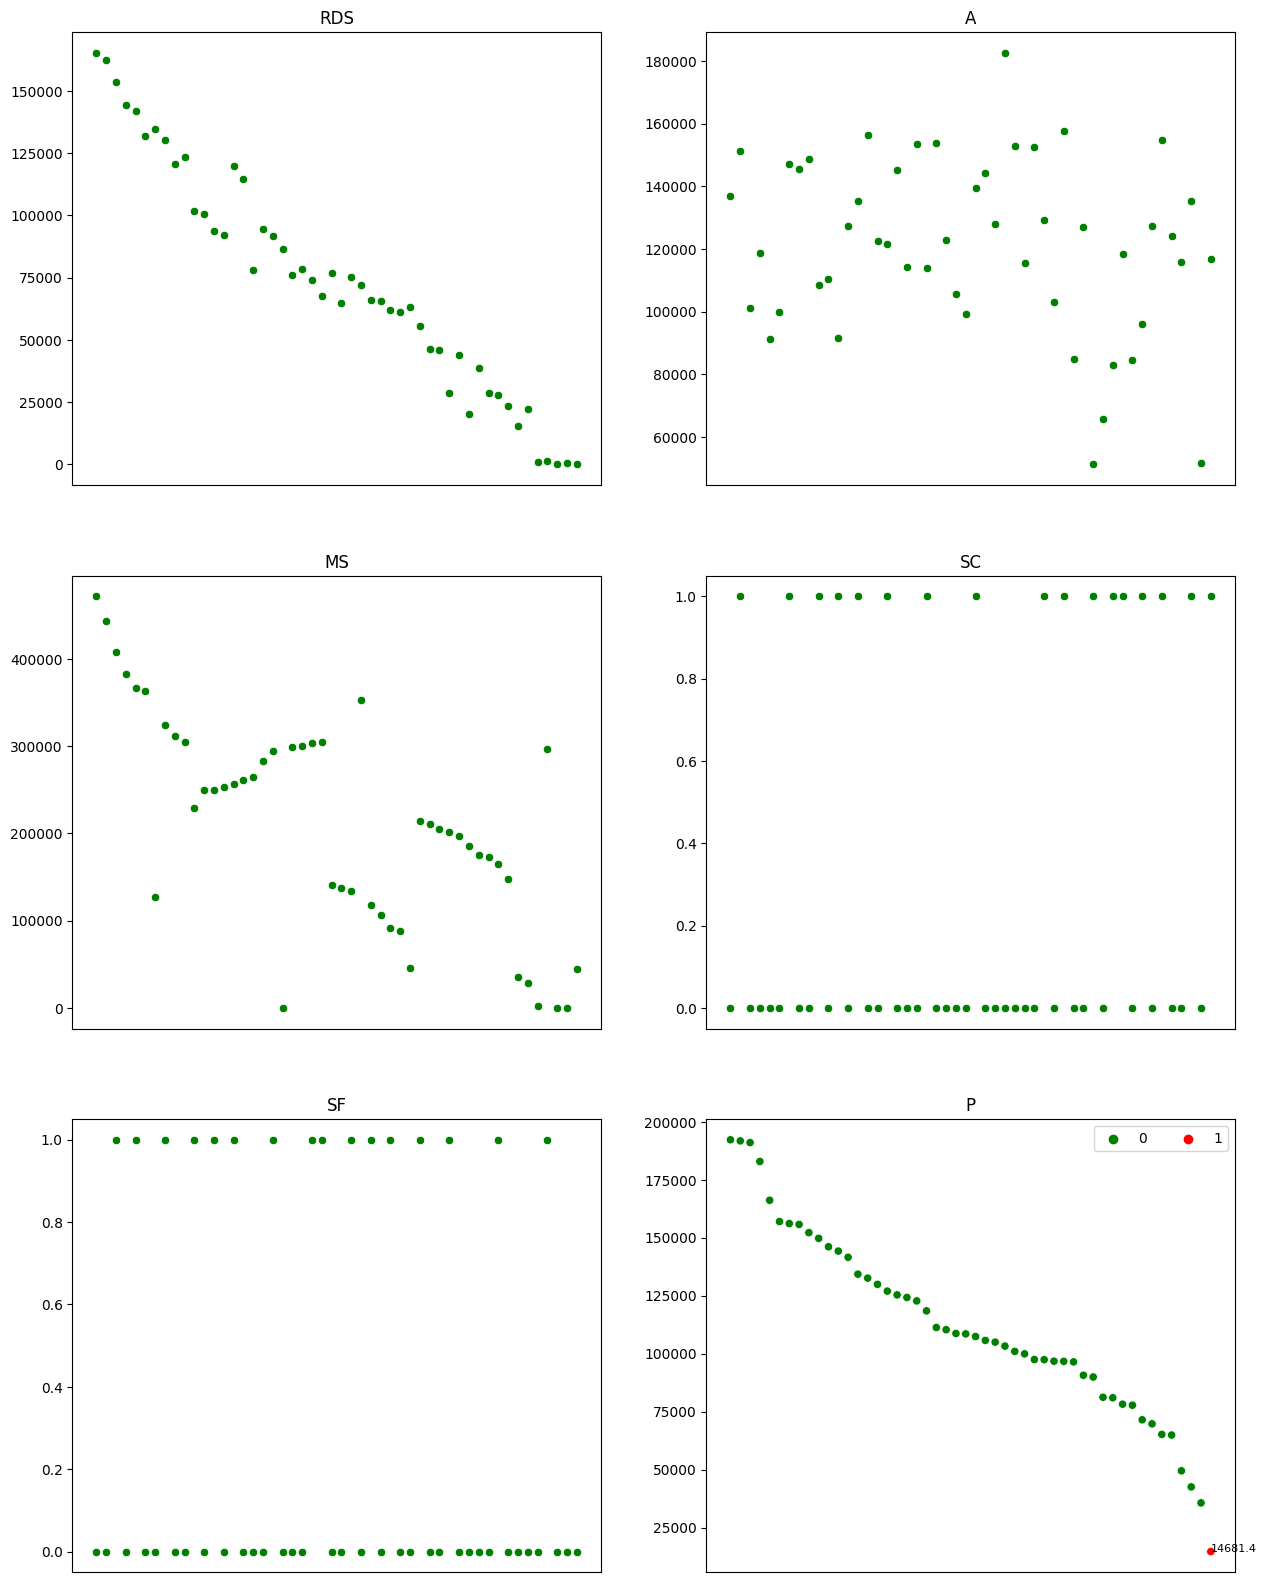

Row indices of potential outliers:
Int64Index([49], dtype='int64')


In [44]:
#FUNCTION TO IDENTIFY OUTLIERS USING IQR METHOD
def iqr_outlier(x,factor):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    min_ = q1 - factor * iqr
    max_ = q3 + factor * iqr
    result_ = pd.Series([0] * len(x))
    result_[((x < min_) | (x > max_))] = 1
    return result_
#SCATTER PLOTS HIGHLIGHTING OUTLIERS CALCULATED USING IQR METHOD
fig, ax = plt.subplots(3, 2, figsize=(15, 20))
row = col = 0
for n,i in enumerate(dfnew.columns):
    if (n % 2 == 0) & (n > 0):
        row += 1
        col = 0
    outliers = iqr_outlier(dfnew[i], 1.5)
   
   
    if sum(outliers) == 0:
        sns.scatterplot(x = np.arange(len(dfnew[i])), y = dfnew[i], ax = ax[row, col], legend=False, color = 'green')
    else:
        sns.scatterplot(x = np.arange(len(dfnew[i])), y = dfnew[i], ax = ax[row, col], hue = outliers, palette = ['green','red'])
    for x,y in zip(np.arange(len(dfnew[i]))[outliers == 1], dfnew[i][outliers == 1]):
        ax[row,col].text(x = x, y = y, s = y, fontsize = 8)
    ax[row,col].set_ylabel("")
    ax[row,col].set_title(i)
    ax[row,col].xaxis.set_visible(False)
    if sum(outliers) > 0:
        ax[row,col].legend(ncol=2)
    col += 1
plt.show()

# Calculate the IQR for each variable
Q1 = dfnew.quantile(0.25)
Q3 = dfnew.quantile(0.75)
IQR = Q3 - Q1

# Set the IQR multiplier for identifying potential outliers
IQR_multiplier = 1.5  # Adjust as needed

# Identify potential outliers based on the IQR method
outliers = ((dfnew < (Q1 - IQR_multiplier * IQR)) | (dfnew > (Q3 + IQR_multiplier * IQR)))

# Get the row indices of potential outliers
row_indices = dfnew.index[outliers.any(axis=1)]

# Print the row indices of potential outliers
print("Row indices of potential outliers:")
print(row_indices)

## Using Z-Scores to detect the outliers 

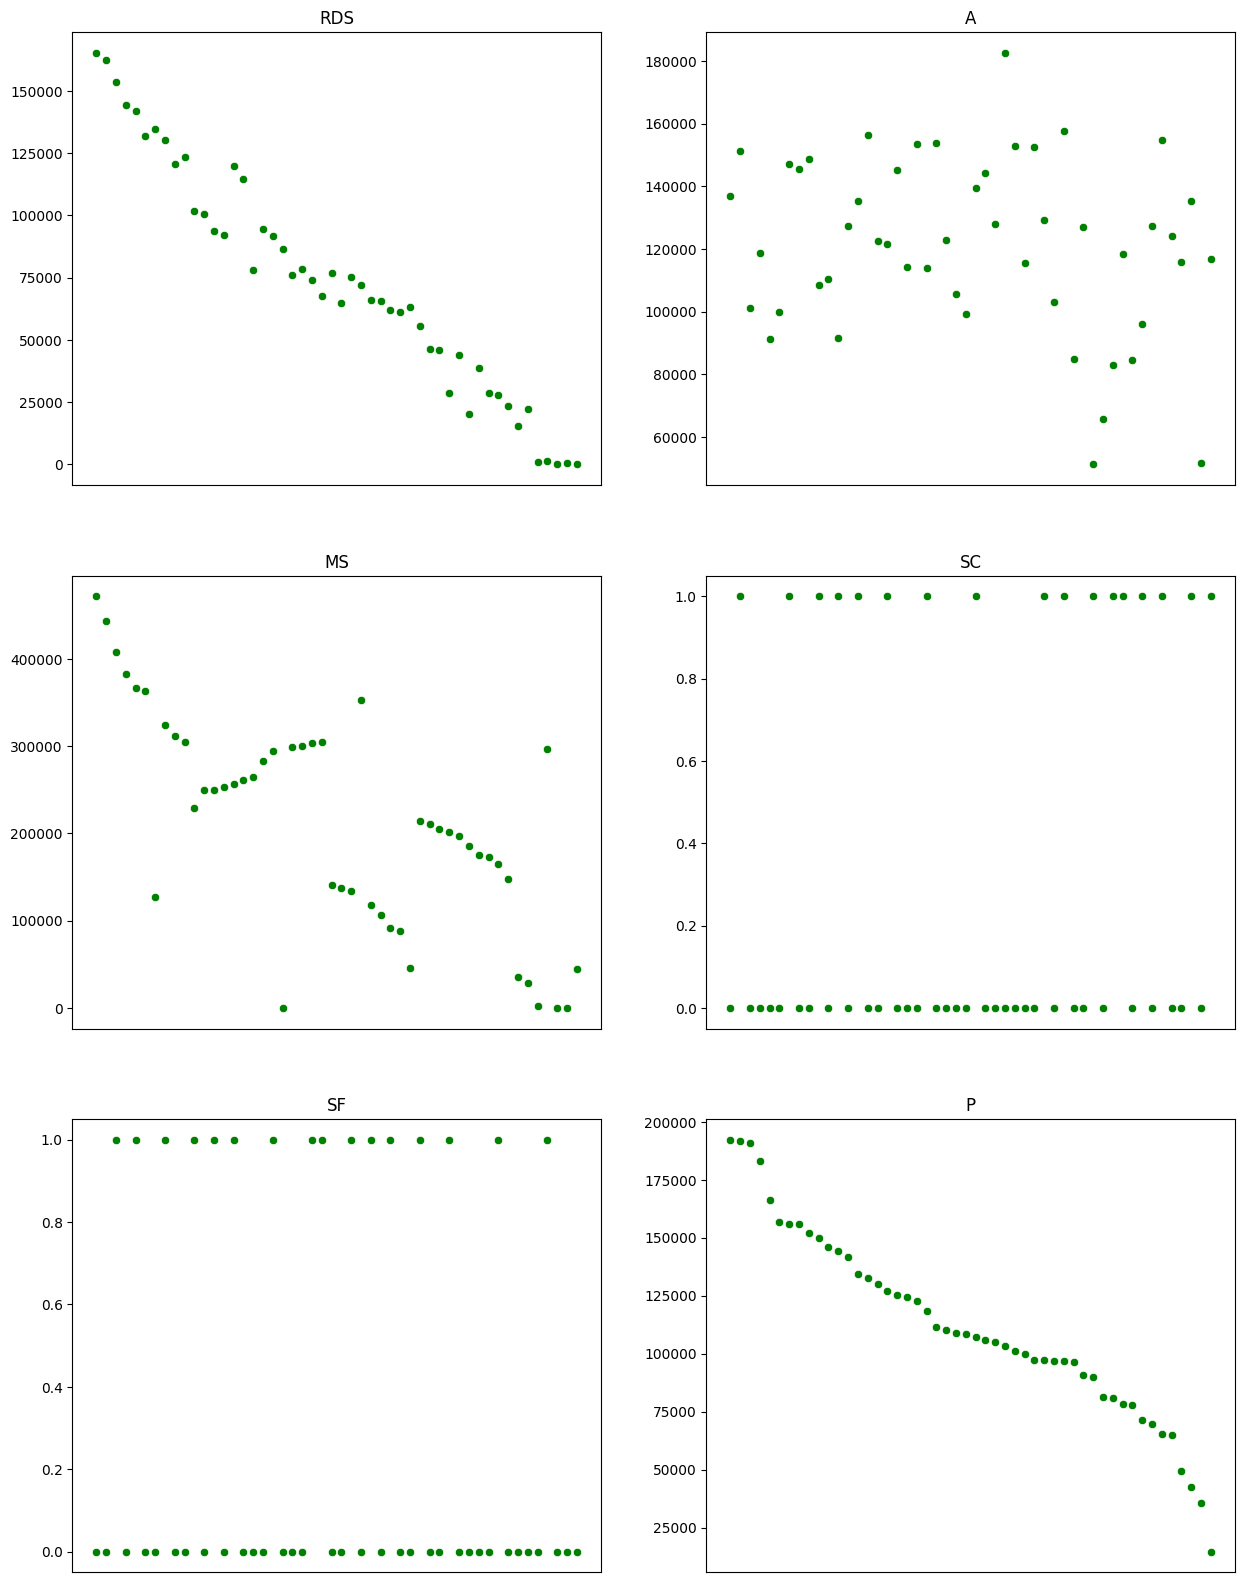

Outliers:
Empty DataFrame
Columns: [RDS, A, MS, SC, SF, P]
Index: []


In [45]:
#FUNCTION TO DETECT OUTLIERS USING Z-SCORE METHOD
def zscore_outlier(x,lb,ub):
    zscore = ((x - x.mean()) / x.std()).copy()
    result_ = pd.Series([0] * len(x))
    result_[((zscore < lb) | (zscore > ub))] = 1
    return result_
#PLOTTING A SCATTER PLOT AND HIGHLIGHTING THE OUTLIERS DETECTED BY Z-SCORE METHOD
fig, ax = plt.subplots(3, 2, figsize=(15, 20))
row = col = 0
for n,i in enumerate(dfnew.columns):
    if (n % 2 == 0) & (n > 0):
        row += 1
        col = 0
    outliers = zscore_outlier(dfnew[i], -3, 3)
   
    if sum(outliers) == 0:
        sns.scatterplot(x = np.arange(len(dfnew[i])), y = dfnew[i], ax = ax[row, col], legend=False, color = 'green')
    else:
        sns.scatterplot(x = np.arange(len(dfnew[i])), y = dfnew[i], ax = ax[row, col], hue = outliers, palette = ['green','red'])
    for x,y in zip(np.arange(len(dfnew[i]))[outliers == 1], dfnew[i][outliers == 1]):
        ax[row,col].text(x = x, y = y, s = y, fontsize = 8)
    ax[row,col].set_ylabel("")
    ax[row,col].set_title(i)
    ax[row,col].xaxis.set_visible(False)
    if sum(outliers) > 0:
        ax[row,col].legend(ncol=2)
    col += 1

plt.show()

# Calculate z-scores for the 'Values' column
z_scores = stats.zscore(dfnew['A'])

# Set a z-score threshold for detecting outliers
z_score_threshold = 3  # Adjust as needed

# Identify outliers based on the z-scores
outliers = dfnew[abs(z_scores) > z_score_threshold]

# Display the outliers
print("Outliers:")
print(outliers)

## From the above methods, record 49 is a outlier and we need to treat this outlier. We are replacing the outlier with the median value. 

In [46]:
# Calculate the IQR for each variable
Q1 = dfnew.quantile(0.25)
Q3 = dfnew.quantile(0.75)
IQR = Q3 - Q1

# Set the IQR multiplier for identifying potential outliers
IQR_multiplier = 1.5  # Adjust as needed

# Iterate through columns and replace outliers with median
for col in dfnew.columns:
    outliers = ((dfnew[col] < (Q1[col] - IQR_multiplier * IQR[col])) | (dfnew[col] > (Q3[col] + IQR_multiplier * IQR[col])))
    median = dfnew[col].median()
    dfnew.loc[outliers, col] = median

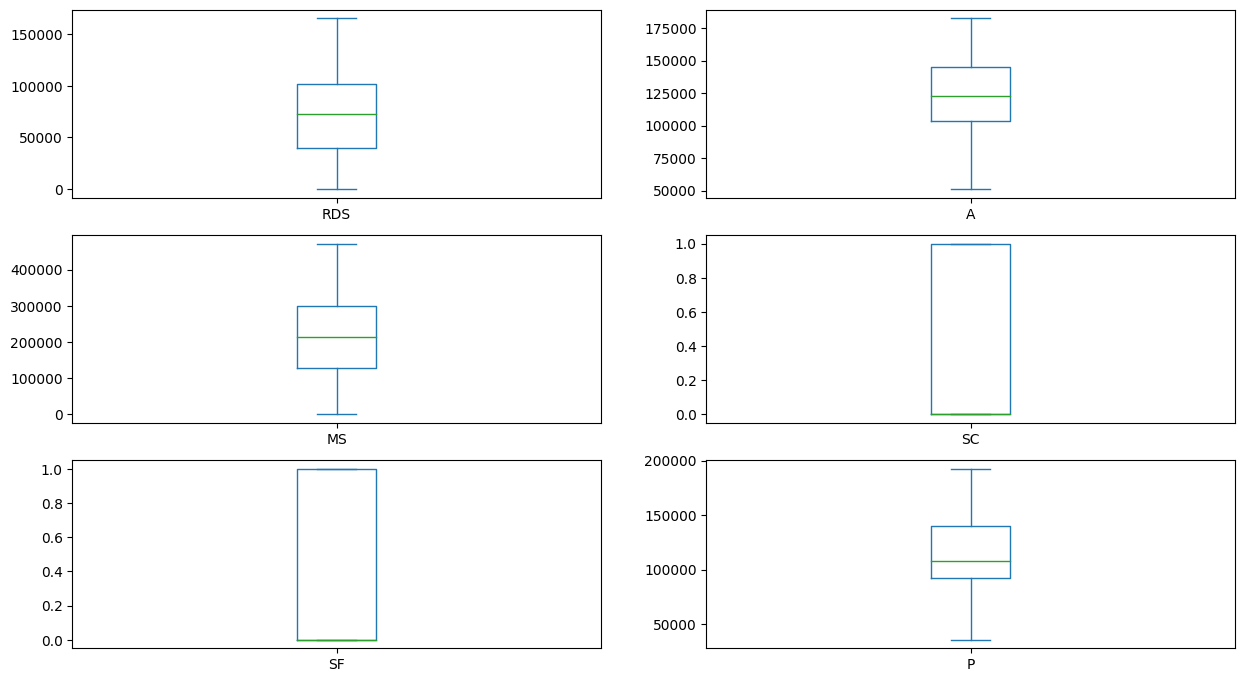

In [47]:
# Visualizing the data after treating the outlier

box_plot = dfnew.plot(kind="box",subplots=True,layout=(7,2),figsize=(15,20));

In [48]:
# Correlation matrix to check the multi collinearity of the features
dfnew.corr()

,RDS,A,MS,SC,SF,P
RDS,1.000000,0.241955,0.724248,-0.143165,0.105711,0.956777
A,0.241955,1.000000,-0.032154,-0.015478,0.010493,0.206243
MS,0.724248,-0.032154,1.000000,-0.168875,0.205685,0.729236
SC,-0.143165,-0.015478,-0.168875,1.000000,-0.492366,-0.086056
SF,0.105711,0.010493,0.205685,-0.492366,1.000000,0.089770
P,0.956777,0.206243,0.729236,-0.086056,0.089770,1.000000


<AxesSubplot: >

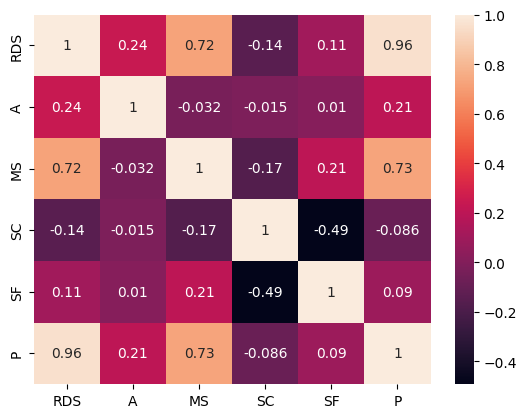

In [49]:
# Heatmaps for the given dataset.
sns.heatmap(dfnew.corr(), annot=True)

## None of the values is near or equal to 1 or -1. Hence no multicolinearity present. 

In [50]:
dfnew.head(5)

,RDS,A,MS,SC,SF,P
0,165349.20,136897.80,471784.10,0,0,192261.83
1,162597.70,151377.59,443898.53,1,0,191792.06
2,153441.51,101145.55,407934.54,0,1,191050.39
3,144372.41,118671.85,383199.62,0,0,182901.99
4,142107.34,91391.77,366168.42,0,1,166187.94


In [51]:
# Calculating VIF Values in order to check the multicollinearity
import statsmodels.formula.api as smf

rsq_rds = smf.ols('RDS~A+MS+SC+SF',data=dfnew).fit().rsquared  
vif_rds = 1/(1-rsq_rds) 

rsq_a = smf.ols('A~RDS+MS+SC+SF',data=dfnew).fit().rsquared  
vif_a = 1/(1-rsq_a) 

rsq_ms = smf.ols('MS~RDS+A+SC+SF',data=dfnew).fit().rsquared  
vif_ms = 1/(1-rsq_ms) 

rsq_sc = smf.ols('SC~RDS+A+MS+SF',data=dfnew).fit().rsquared  
vif_sc = 1/(1-rsq_sc) 

rsq_sf = smf.ols('SF~RDS+A+MS+SC',data=dfnew).fit().rsquared  
vif_sf = 1/(1-rsq_sf) 

# Storing vif values in a data frame
d1 = {'Variables':['RDS','A','MS','SC','SF'],'VIF':[vif_rds,vif_a,vif_ms,vif_sc,vif_sf]}
Vif_frame = pd.DataFrame(d1)  
Vif_frame

,Variables,VIF
0,RDS,2.495511
1,A,1.177766
2,MS,2.416797
3,SC,1.335061
4,SF,1.361299


## VIF value for all the features is very low. Hence all the variables are significant and there is no presence of multicollinearity.

In [52]:
dfnew.head(5)

,RDS,A,MS,SC,SF,P
0,165349.20,136897.80,471784.10,0,0,192261.83
1,162597.70,151377.59,443898.53,1,0,191792.06
2,153441.51,101145.55,407934.54,0,1,191050.39
3,144372.41,118671.85,383199.62,0,0,182901.99
4,142107.34,91391.77,366168.42,0,1,166187.94


## From both the correlation matrix and the VIF value show that none of the feature depend on each other. Hence there is no multicollinearity present in the dataset.

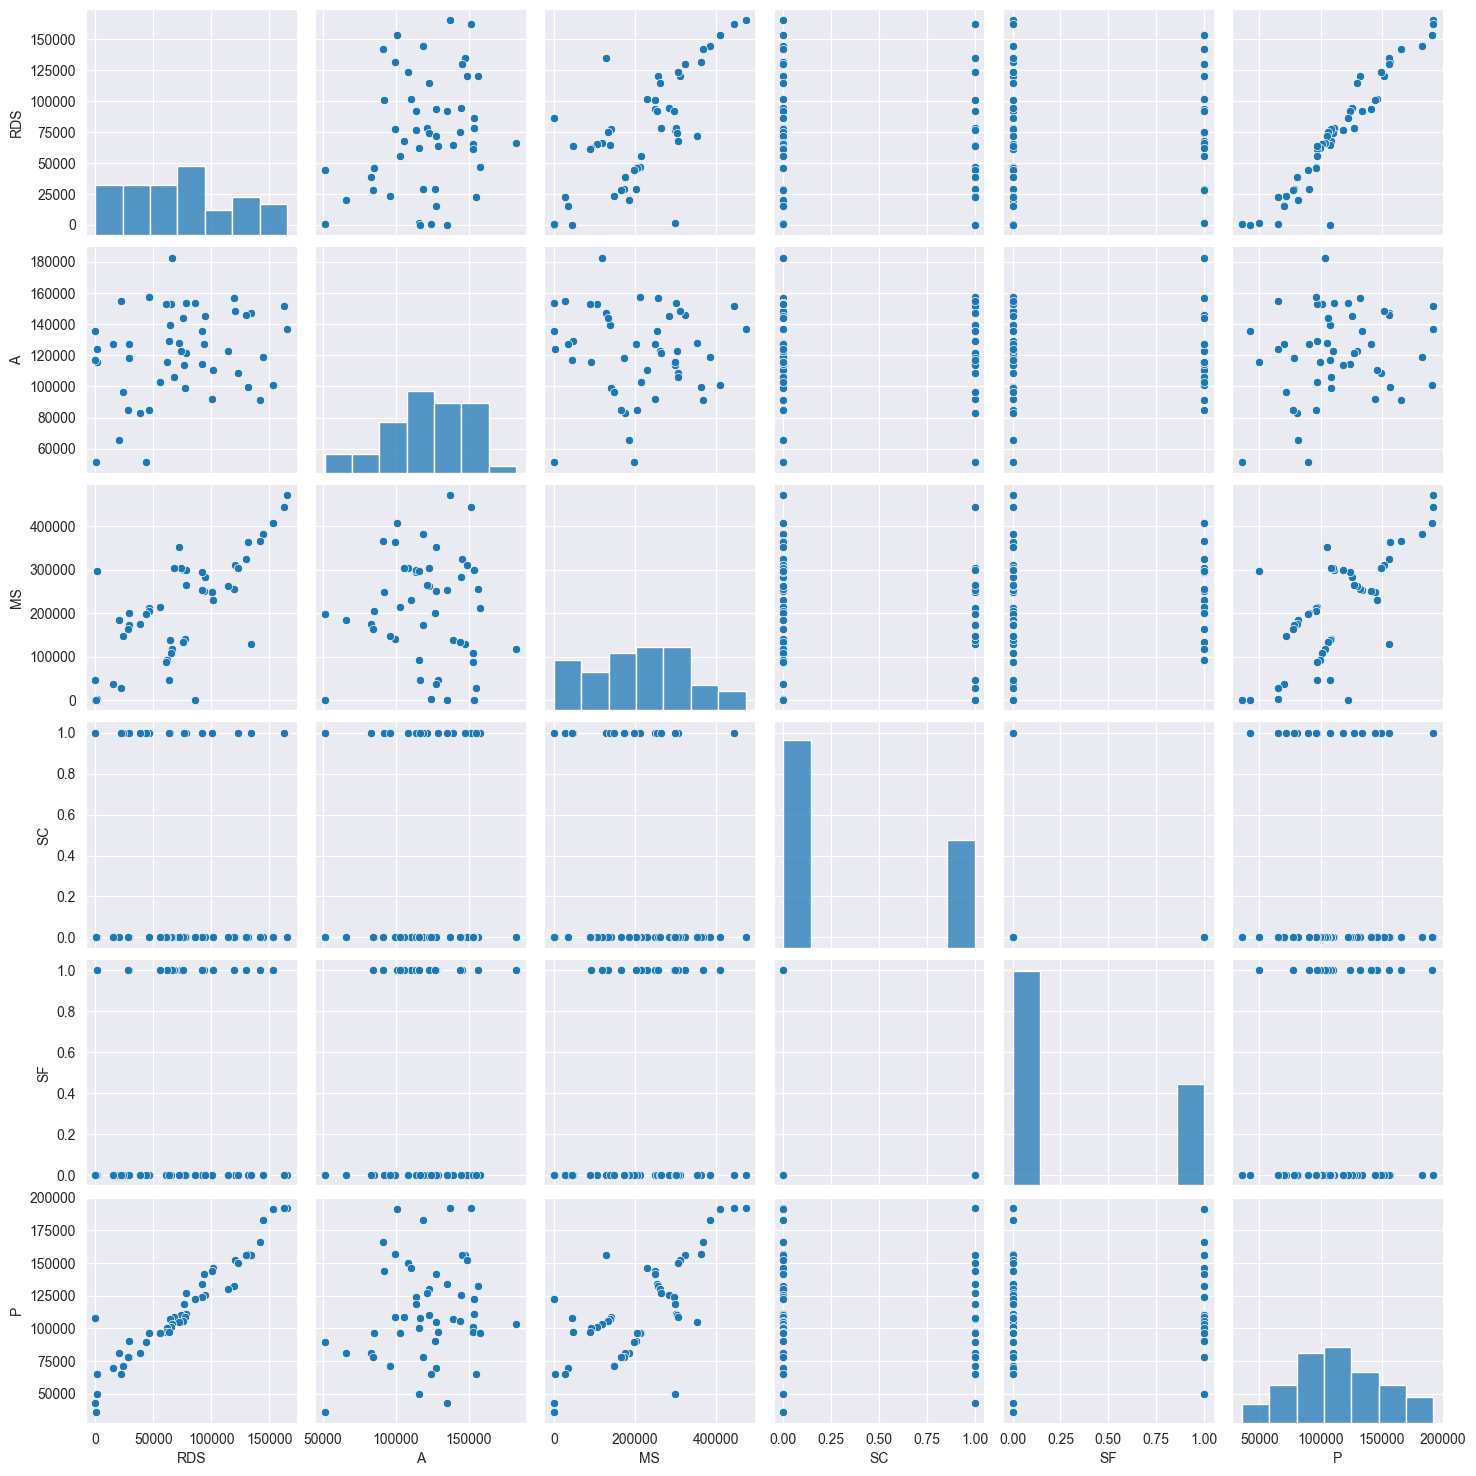

In [53]:
# Drawing Histogram to check the distribution of the data.
#Format the plot background and scatter plots for all the variables
sns.set_style(style='darkgrid')
sns.pairplot(dfnew)

## Each of the histogram shows that most the features are normally distributed. 

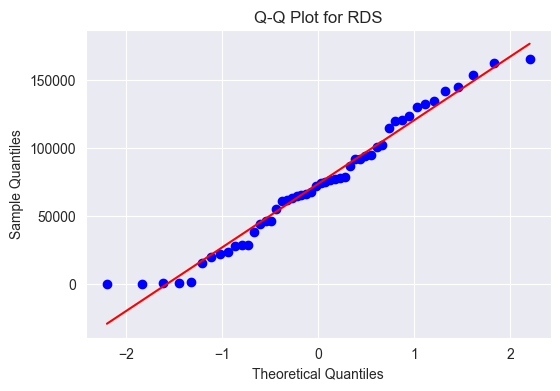

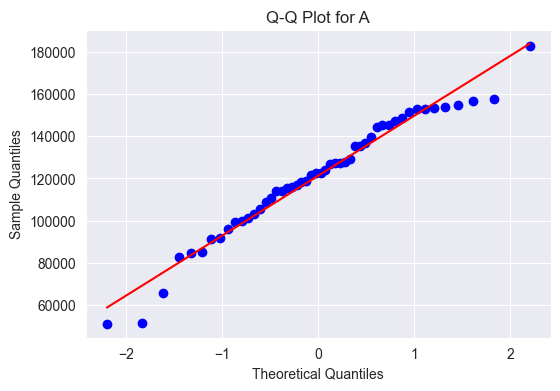

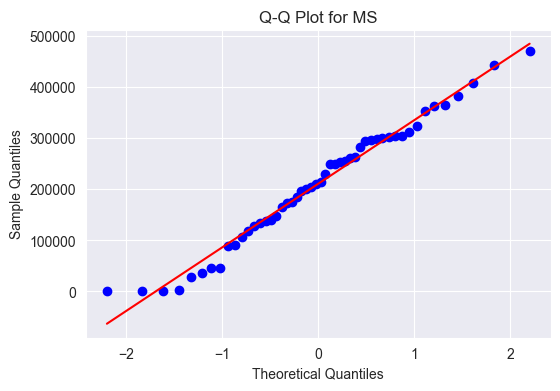

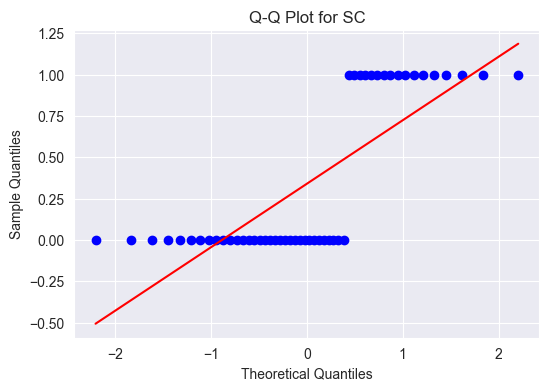

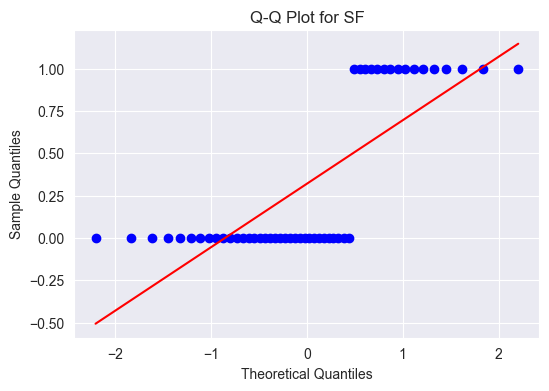

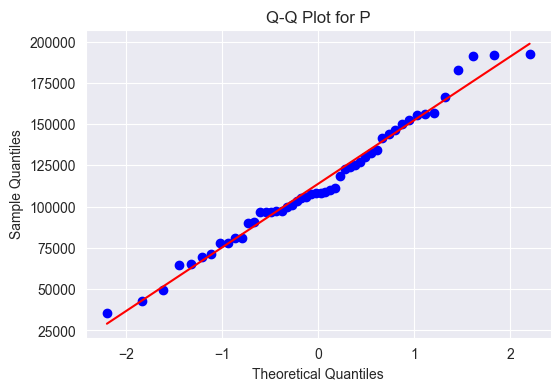

In [54]:
# Using Q-Q plot for checking the data distribution
# Create Q-Q plots for each variable in separate graphs
for col in dfnew.columns:
    plt.figure(figsize=(6, 4))
    stats.probplot(dfnew[col], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot for {col}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.grid(True)
    plt.show()

## Each of the Q-Q plot shows that each of the feature is normally distributed. 
## Hence we can use Standardization for transformation.

In [145]:
from sklearn.preprocessing import StandardScaler
# Initialize the StandardScaler
scaler = StandardScaler()
# Fit and transform the data using standardization
standardized_data = scaler.fit_transform(dfnew)
# Create a new DataFrame with the standardized data
stnd_df = pd.DataFrame(standardized_data, columns=dfnew.columns)

In [146]:
stnd_df.head(2)

,RDS,A,MS,SC,SF,P
0,2.016411,0.560753,2.153943,-0.717741,-0.685994,2.095275
1,1.955860,1.082807,1.923600,1.393261,-0.685994,2.082718


In [147]:
#Build model
import statsmodels.formula.api as smf 
model1 = smf.ols('P~RDS+A+MS+SC+SF',data=stnd_df).fit()

In [148]:
(model1.rsquared,model1.aic)

(0.9215465803146117, 26.631342814606583)

In [149]:
# P~RDS+A+MS+SC+SF
#Exclude variable "WT" and generate R-Squared and AIC values
final_ml_RDS= smf.ols('P~A+MS+SC+SF',data = stnd_df).fit()
(final_ml_RDS.rsquared,final_ml_RDS.aic)

(0.5890643430558629, 107.42792186102373)

In [150]:
final_ml_A= smf.ols('P~RDS+MS+SC+SF',data = stnd_df).fit()
(final_ml_A.rsquared,final_ml_A.aic)

(0.9214479153413978, 24.694184551661607)

In [151]:
final_ml_MS= smf.ols('P~RDS+A+SC+SF',data = stnd_df).fit()
(final_ml_MS.rsquared,final_ml_MS.aic)

(0.9190338600974581, 26.20764144039609)

In [152]:
final_ml_SC= smf.ols('P~RDS+MS+A+SF',data = stnd_df).fit()
(final_ml_SC.rsquared,final_ml_SC.aic)

(0.9187491477739463, 26.38315487590461)

In [153]:
final_ml_SF= smf.ols('P~RDS+MS+SC+A',data = stnd_df).fit()
(final_ml_SF.rsquared,final_ml_SF.aic)

(0.921503551211406, 24.65875864152129)

In [154]:
# Dictionary containing dot values and corresponding column names
r2_aic_values = {
    'Models': ["model1", "final_ml_RDS", "final_ml_A", "final_ml_MS", "final_ml_SC", "final_ml_SF"],
    'RSquared': [0.9215465803146117, 0.5890643430558629, 0.9214479153413978, 0.9190338600974581, 0.9187491477739463, 0.921503551211406],
    'AIC': [26.631342814606583, 107.42792186102373, 24.694184551661607, 26.20764144039609, 26.38315487590461, 24.65875864152129]
}

r2_aic_table = pd.DataFrame(r2_aic_values)

r2_aic_table

,Models,RSquared,AIC
0,model1,0.921547,26.631343
1,final_ml_RDS,0.589064,107.427922
2,final_ml_A,0.921448,24.694185
3,final_ml_MS,0.919034,26.207641
4,final_ml_SC,0.918749,26.383155
5,final_ml_SF,0.921504,24.658759


### From the above table we can see that model1 has highest R-squared value and low AIC. Hence model1 will be considered as for the final model building process

In [155]:
final_model = smf.ols('P~RDS+A+MS+SC+SF',data=stnd_df).fit()

In [156]:
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      P   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     103.4
Date:                Tue, 22 Aug 2023   Prob (F-statistic):           3.60e-23
Time:                        00:06:46   Log-Likelihood:                -7.3157
No. Observations:                  50   AIC:                             26.63
Df Residuals:                      44   BIC:                             38.10
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.025e-16      0.042  -9.53e-15      1.000      -0.085       0.085
RDS            0.9109      0.067     13.655      0.000       0.776       1.045
A             -0.0108      0.046     -0.235      0.815      -0.103       0.082
MS             0.0779      0.066      1.187      0.242      -0.054       0.210
SC             0.0611      0.049      1.253      0.217      -0.037       0.159
SF             0.0077      0.049      0.155      0.877      -0.092       0.107
==============================================================================
Omnibus:                       42.397   Durbin-Watson:                   1.676
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.850
Skew:                           2.127   Prob(JB):                     1.20e-40
Kurtosis:                      11.376   Cond. No.                         2.99
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### R-squared > 90%.  
### Adj. R-squared > 90%
### Adj. R-squared < R-squared
### Hence the model is good.

## Residual Analysis
## Test for Normality of Residuals (Q-Q Plot)

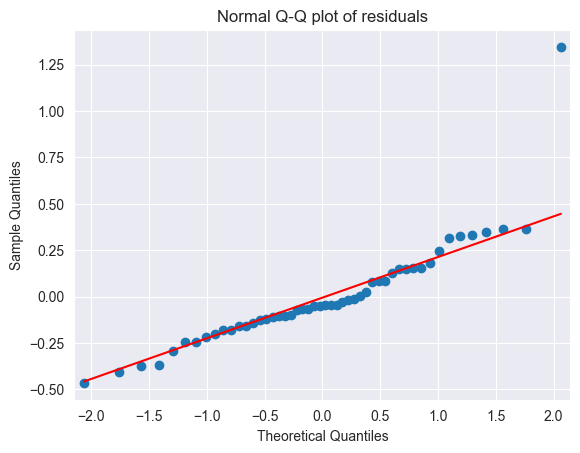

In [157]:
# Residual Analysis
import statsmodels.api as sm
qqplot=sm.qqplot(final_model.resid,line='q') # line = 45 to draw the diagnoal line
plt.title("Normal Q-Q plot of residuals")
plt.show()

### Points are Close to the line hence the model is good

## Residual Plot for Homoscedasticity

In [158]:
# Checking for Homoscedasticity
def get_standardized_values( vals ):
    return (vals - vals.mean())/vals.std()

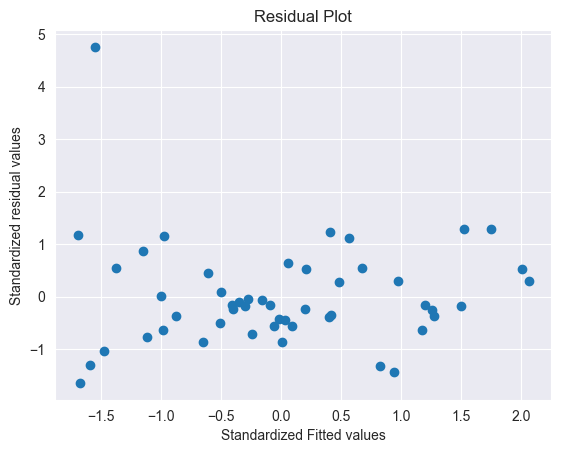

In [159]:
plt.scatter(get_standardized_values(final_model.fittedvalues),
            get_standardized_values(final_model.resid))

plt.title('Residual Plot')
plt.xlabel('Standardized Fitted values')
plt.ylabel('Standardized residual values')
plt.show()

### Model is showing Homoscedasticity. Hence model is good.

###  Residual Vs Regressors

In [160]:
# Create a copy of the DataFrame
stnd_df_copy = stnd_df.copy()

In [161]:
stnd_df_copy.head(2)

,RDS,A,MS,SC,SF,P
0,2.016411,0.560753,2.153943,-0.717741,-0.685994,2.095275
1,1.955860,1.082807,1.923600,1.393261,-0.685994,2.082718


In [162]:
# Removing the Target variable to draw Residual vs Regressors plot for each feature.
stnd_df_copy = stnd_df_copy.drop(columns=df.columns[-1])

In [163]:
stnd_df_copy.head(2)

,RDS,A,MS,SC,SF
0,2.016411,0.560753,2.153943,-0.717741,-0.685994
1,1.955860,1.082807,1.923600,1.393261,-0.685994


eval_env: 1


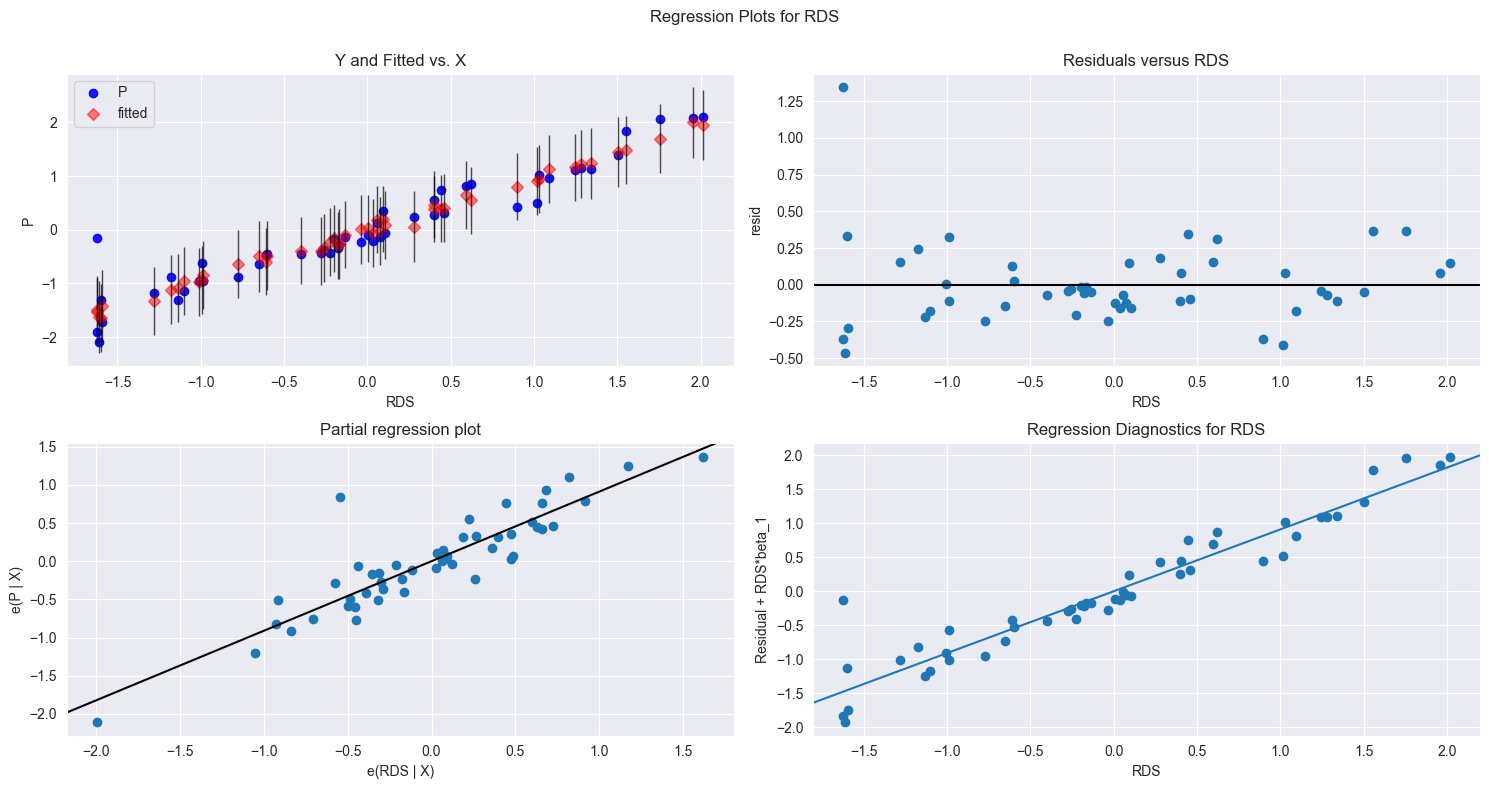

eval_env: 1


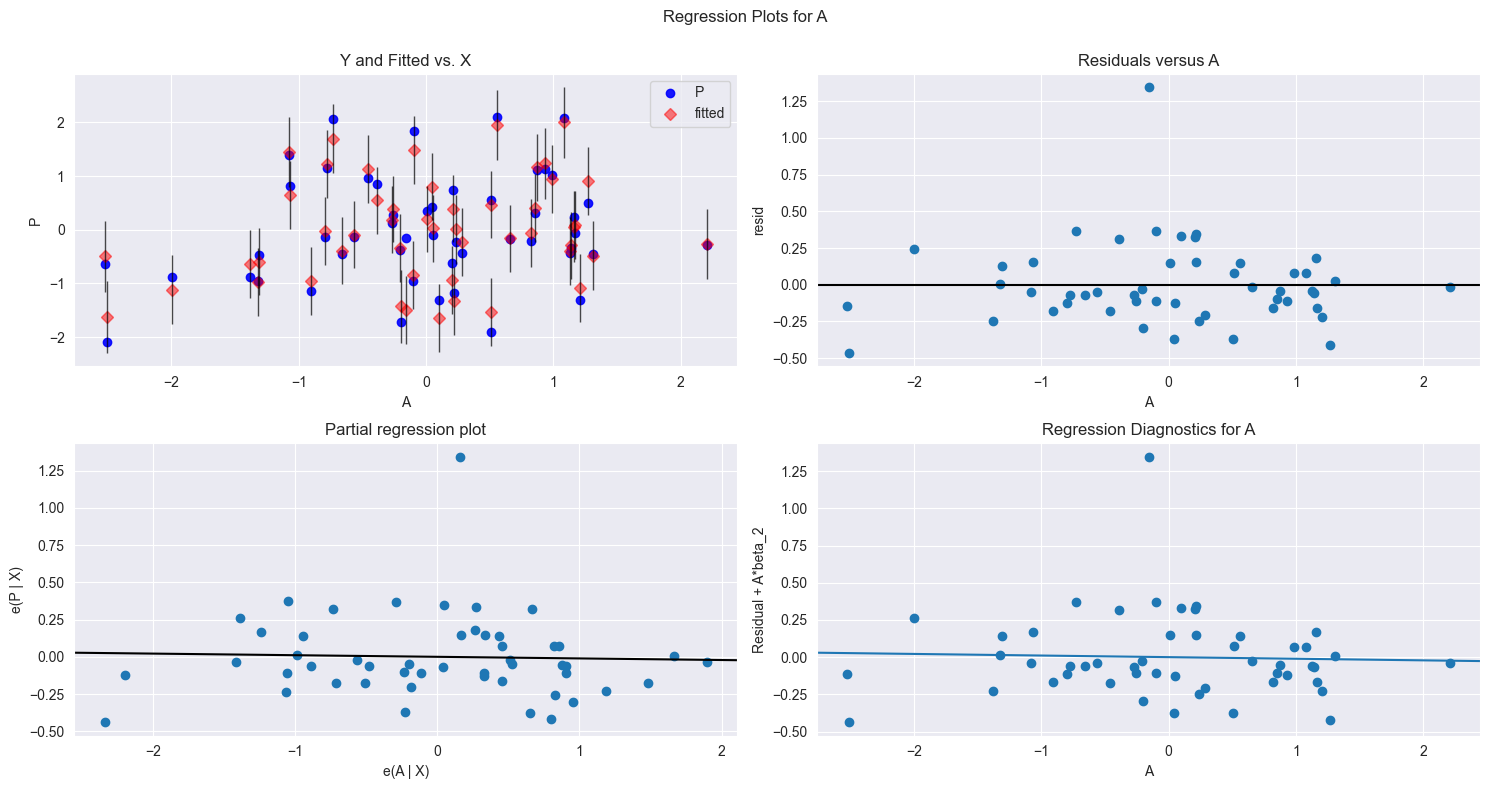

eval_env: 1


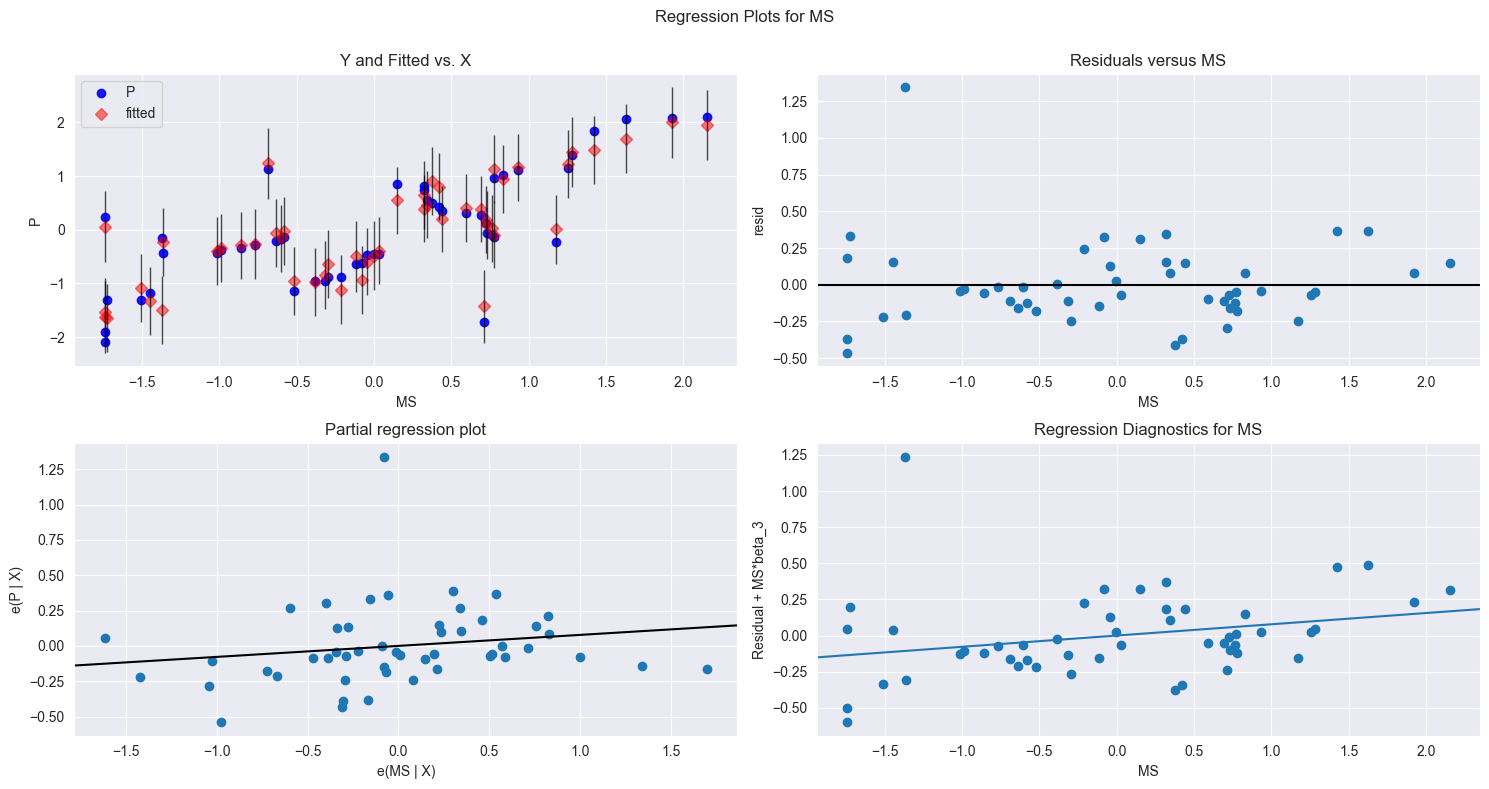

eval_env: 1


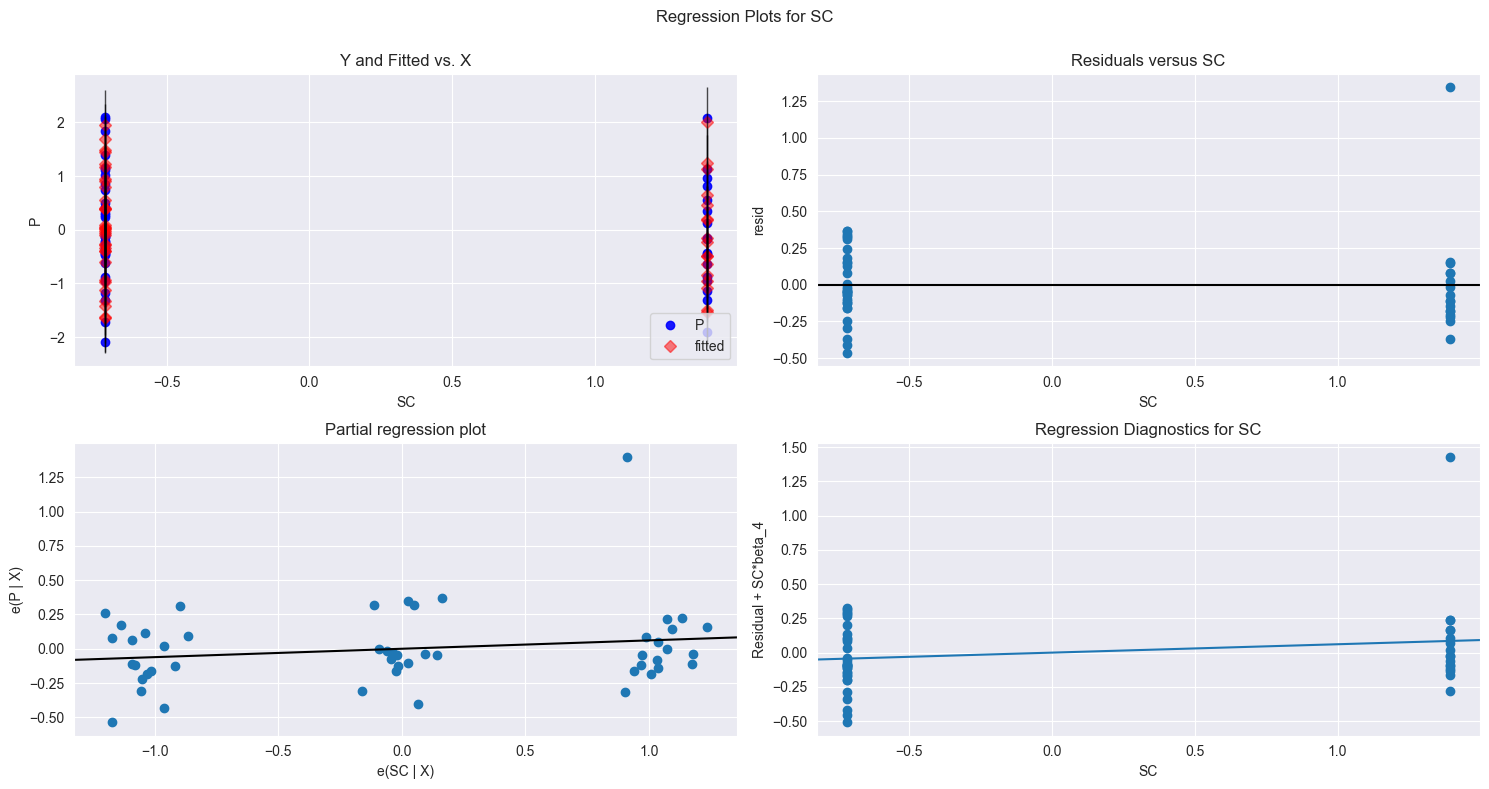

eval_env: 1


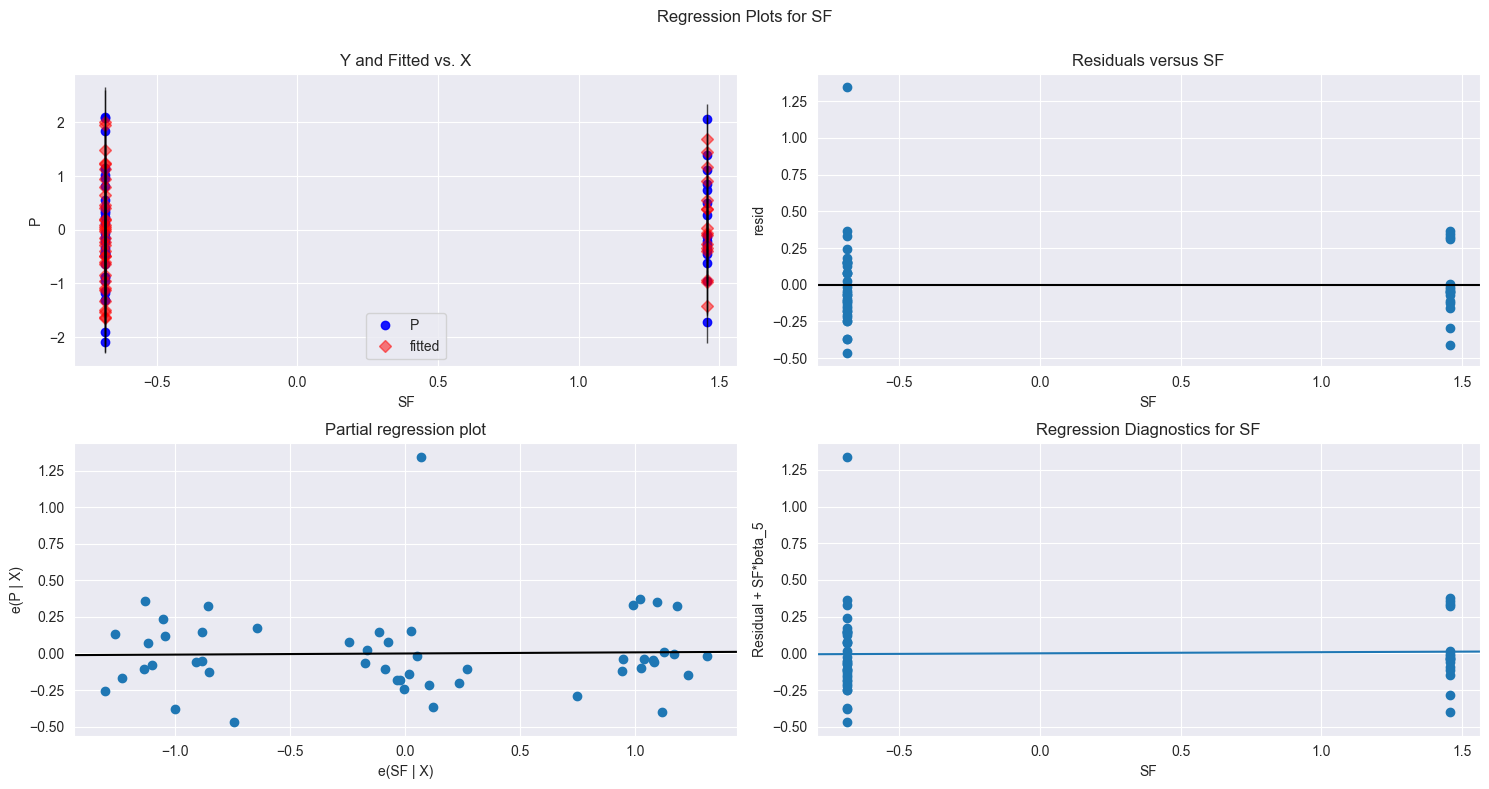

In [164]:
# Create regression diagnostics plots for each variable by dropping the Target variable.
for col in stnd_df_copy.columns:
    fig = plt.figure(figsize=(15, 8))
    fig = sm.graphics.plot_regress_exog(final_model, col, fig=fig)
    plt.title(f"Regression Diagnostics for {col}")
    plt.show()

### From the above graphs we can conclude that most of the fitted values is near to actual values and there no such patterns present in the residual vs variable graph. Hence the model is significantly accurate.

## Model Deletion Diagnostics
## Detecting Influencers/Outliers
## Cook’s Distance

In [165]:
model_influence = final_model.get_influence()
(c, _) = model_influence.cooks_distance

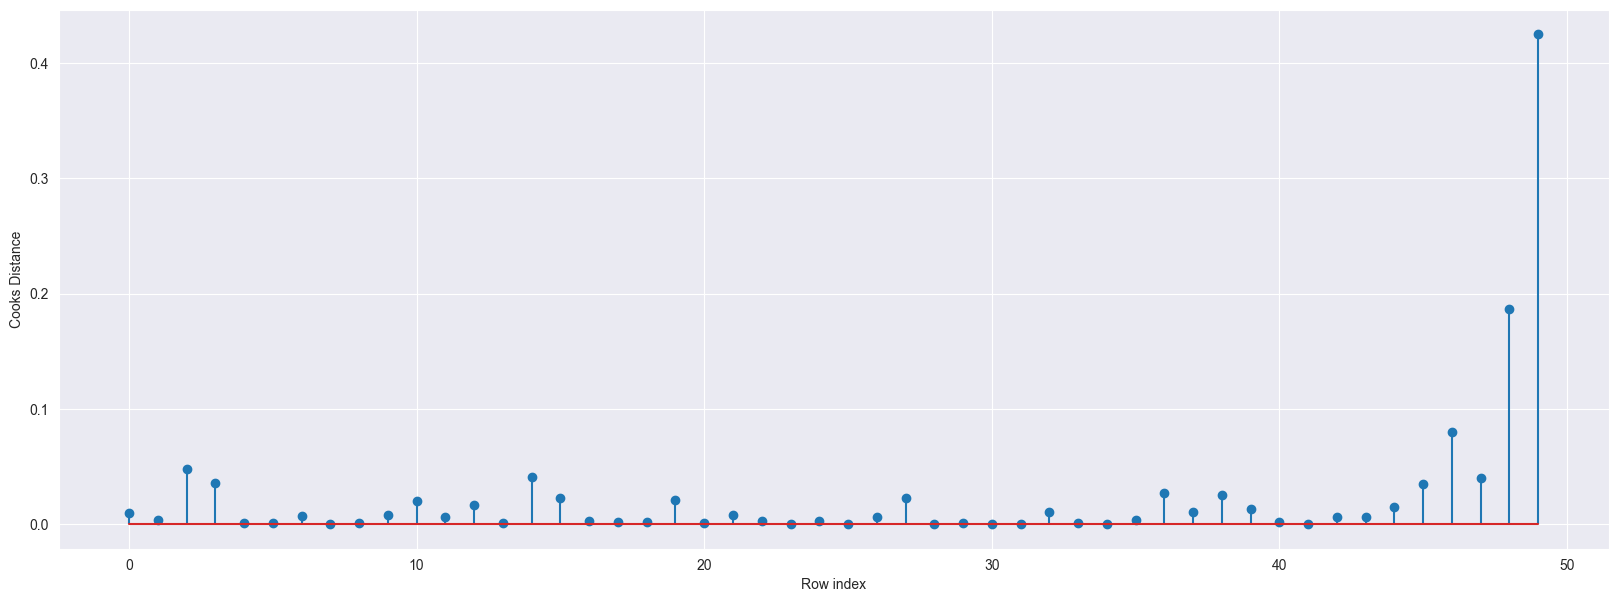

In [166]:
#Plot the influencers values using stem plot
fig = plt.subplots(figsize=(20, 7))
plt.stem(np.arange(len(norm_df)), np.round(c, 3))
plt.xlabel('Row index')
plt.ylabel('Cooks Distance')
plt.show()

In [167]:
#index and value of influencer where c is more than .5
(np.argmax(c),np.max(c))

(49, 0.425294153581431)

### From the above graph we can conclude that none of the cook's distance is greater than one. Hence none are influencers.

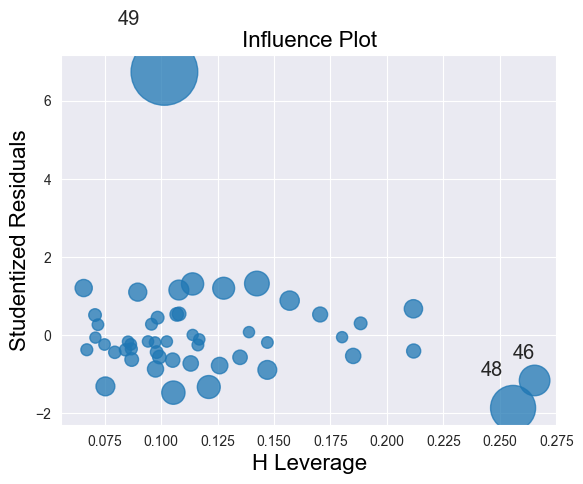

In [168]:
from statsmodels.graphics.regressionplots import influence_plot
influence_plot(final_model)
plt.show()

In [113]:
k = dfnew.shape[1]
n = dfnew.shape[0]
leverage_cutoff = 3*((k + 1)/n)
leverage_cutoff

0.42000000000000004

### None of the datapoints are present to the right of the leverage cutoff. Hence none of the points are influencers.

### Predicting for new data

In [169]:
#New data for prediction
new_data=pd.DataFrame({'RDS':20000,"A":20000,"MS":50000,"SC":0, "SF":1 },index=[1])

In [170]:
# Predicted value
predicted_value = final_model.predict(new_data)
predicted_value

1    21898.516198
dtype: float64